# Part 1 — Exploratory Data Analysis (EDA)

This notebook explores campaign performance and lead quality to set up downstream analysis and dashboarding.

Objectives:
- Inspect and understand the raw datasets (schema, shape, sample rows)
- Clean and deduplicate leads; define status buckets for qualified/non-qualified
- Explore qualified rate by campaign and temporal trends
- Build core campaign metrics (CTR, CPL) from insights and leads
- Export derived datasets consumed by the dashboard and later parts

## Setup
Import core libraries used across the notebook.

In [1]:
import pandas as pd
import numpy as np

## Load Data
Read raw CSVs from `part2/data/` as the canonical source.

### Dataset Overview
Quick schema, shape, and sample rows for each dataset.

In [ ]:
cl=pd.read_csv('part2/data/campaign_leads.csv')
camp=pd.read_csv('part2/data/campaigns.csv')
ins=pd.read_csv('part2/data/insights.csv')
ls=pd.read_csv('part2/data/lead_status_changes.csv')

In [ ]:
# Let's examine the basic information about each dataset
print("Campaign Leads Dataset:")
print(cl.info())
print("\nShape:", cl.shape)
print("\nFirst few rows:")
print(cl.head())

print("\n" + "="*50 + "\n")

print("Campaigns Dataset:")
print(camp.info())
print("\nShape:", camp.shape)
print("\nFirst few rows:")
print(camp.head())

print("\n" + "="*50 + "\n")

print("Insights Dataset:")
print(ins.info())
print("\nShape:", ins.shape)
print("\nFirst few rows:")
print(ins.head())

print("\n" + "="*50 + "\n")

print("Lead Status Changes Dataset:")
print(ls.info())
print("\nShape:", ls.shape)
print("\nFirst few rows:")
print(ls.head())

In [3]:
cl.head()

,id,campaign_id,name,email,phone,lead_status,added_date
0,77930,6496,Vicky Mohr Sr.,smith.oren@example.org,+2015628437879,UNKNOWN,2024-06-01 17:00:40
1,77942,6496,Clovis Mueller,toy.korey@example.net,+1-615-909-5723,UNKNOWN,2024-06-01 18:22:00
2,77964,6493,Austin Ondricka II,hveum@example.org,+2014034035897,NOT_QUALIFIED,2024-06-01 21:56:33
3,77983,6500,Jaquan Kuhn,greenholt.elsa@example.com,310-242-6257,UNKNOWN,2024-06-02 01:13:19
4,77988,6496,Prof. Grayson Collier,obie83@example.com,+2016402961934,UNKNOWN,2024-06-02 01:41:56


In [4]:
cl.id.value_counts().sort_values(ascending=False)

id
78016     1
288464    1
77930     1
77942     1
77964     1
         ..
283952    1
284010    1
284163    1
284173    1
284250    1
Name: count, Length: 56965, dtype: int64

## Lead Cleaning & Status Categories
- Deduplicate leads at the (campaign_id, phone) grain.
- Define buckets for qualified, non-qualified, and undetermined statuses.

In [5]:
cl1=cl.drop_duplicates(subset=['campaign_id','phone'],keep='last')

In [6]:
cl1.head()

,id,campaign_id,name,email,phone,lead_status,added_date
0,77930,6496,Vicky Mohr Sr.,smith.oren@example.org,+2015628437879,UNKNOWN,2024-06-01 17:00:40
1,77942,6496,Clovis Mueller,toy.korey@example.net,+1-615-909-5723,UNKNOWN,2024-06-01 18:22:00
2,77964,6493,Austin Ondricka II,hveum@example.org,+2014034035897,NOT_QUALIFIED,2024-06-01 21:56:33
3,77983,6500,Jaquan Kuhn,greenholt.elsa@example.com,310-242-6257,UNKNOWN,2024-06-02 01:13:19
4,77988,6496,Prof. Grayson Collier,obie83@example.com,+2016402961934,UNKNOWN,2024-06-02 01:41:56


In [7]:
cl1.lead_status.value_counts()

lead_status
UNKNOWN           27582
NEW_LEAD          14724
QUALIFIED          4063
NO_ANSWER          3124
NOT_QUALIFIED      2821
CALL_AGAIN          923
FOLLOW_UP           921
WHATSAPP            844
LOW_BUDGET          547
SWITCHED_OFF        440
SPAM                304
WRONG_NUMBER        299
HIGH_INTEREST       156
DONE_DEAL            84
ALREADY_BOUGHT       51
RESALE_REQUEST       45
MEETING_DONE         37
Name: count, dtype: int64

#### QUESTIONS:
1. Should the unknown be treated as New leads?
2. What categories are considered Qualified leads?
3. What categories are considered closed/won?


In [8]:
#ASSUMPTION
qualified_status=['QUALIFIED','DONE_DEAL','MEETING_DONE']
non_qualified_status=['NOT_QUALIFIED','LOW_BUDGET','SPAM','WRONG_NUMBER','ALREADY_BOUGHT','RESALE_REQUEST']
undetermined_status=['UNKNOWN','NO_ANSWER','CALL_AGAIN','FOLLOW_UP','WHATSAPP','SWITCHED_OFF','HIGH INTEREST','RESALE_REQUEST']

## Qualified Leads Percentage
Compute campaign-level qualified percentage = qualified / (qualified + non-qualified).

In [9]:
count_of_qualified_leads=cl1['lead_status'].isin(qualified_status).sum()
count_of_non_qualified_leads=cl1['lead_status'].isin(non_qualified_status).sum()
qualified_leads_percentage=(count_of_qualified_leads/(count_of_qualified_leads+count_of_non_qualified_leads))*100
qualified_leads_percentage

np.float64(50.70900496909465)

Total campaigns: 4022
Distribution (value counts of percentages):
qualified_percentage
0.00      3362
1.85         1
3.57         1
5.00         1
5.56         1
          ... 
97.37        1
98.28        1
99.00        1
99.19        1
100.00     345
Name: count, Length: 120, dtype: int64


C:\Users\ajax2\AppData\Local\Temp\ipykernel_13924\3458785984.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qualified_by_campaign = cl1.groupby('campaign_id').apply(


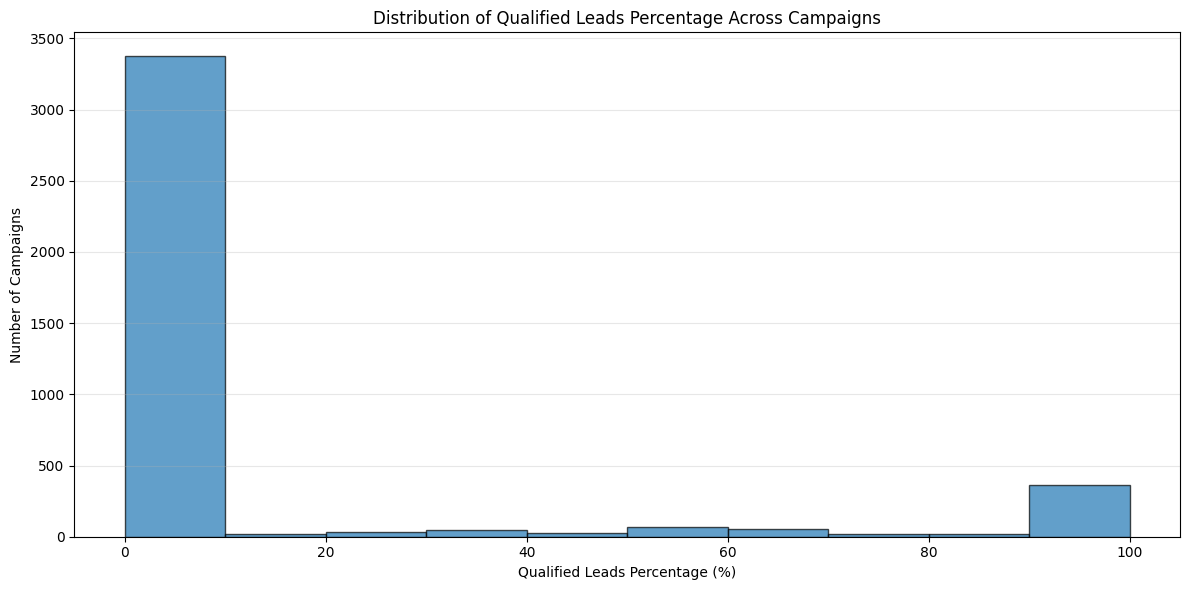

,campaign_id,qualified_percentage
0,6493,0.0
1,6496,0.0
2,6497,0.0
3,6500,0.0
4,6502,0.0


In [10]:
# Recreate qualified leads percentage per campaign and plot histogram (restored)
# Matches the original logic: qualified / (qualified + non-qualified) * 100, else 0 when denominator is 0
import matplotlib.pyplot as plt

qualified_by_campaign = cl1.groupby('campaign_id').apply(
    lambda x: (
        (x['lead_status'].isin(qualified_status).sum() / 
         (x['lead_status'].isin(qualified_status).sum() + x['lead_status'].isin(non_qualified_status).sum())) * 100
        if (x['lead_status'].isin(qualified_status).sum() + x['lead_status'].isin(non_qualified_status).sum()) > 0
        else 0
    )
).reset_index(name='qualified_percentage')

# Round for readability
qualified_by_campaign['qualified_percentage'] = qualified_by_campaign['qualified_percentage'].round(2)

# Quick sanity output
print('Total campaigns:', qualified_by_campaign.shape[0])
print('Distribution (value counts of percentages):')
print(qualified_by_campaign['qualified_percentage'].value_counts().sort_index())

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(qualified_by_campaign['qualified_percentage'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Qualified Leads Percentage (%)')
plt.ylabel('Number of Campaigns')
plt.title('Distribution of Qualified Leads Percentage Across Campaigns')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# show head
qualified_by_campaign.head()

In [11]:
qualified_by_campaign.qualified_percentage.value_counts()

qualified_percentage
0.00      3362
100.00     345
50.00       51
33.33       32
66.67       26
          ... 
58.33        1
38.10        1
27.27        1
38.46        1
21.35        1
Name: count, Length: 120, dtype: int64

#### OBSERVATIONS 
1. Most of the concluded campaigns have zero qualified leads
2. The higher percentage of qualified leads probably corresponds to a lower leads count, but will not dig further

#### QUESTIONS:
1. Are there duplicates in the campaign ID as in has there any campaign was turned off and on again?
2. What is the budget per lead

In [12]:
# Add duration column to camp dataframe
camp['start_time'] = pd.to_datetime(camp['start_time'])
camp['stop_time'] = pd.to_datetime(camp['stop_time'])
camp['duration'] = (camp['stop_time'] - camp['start_time']).dt.days + 1
camp[['id', 'project_name', 'start_time', 'stop_time', 'duration', 'daily_budget']].head()

,id,project_name,start_time,stop_time,duration,daily_budget
0,4869,New Capital- General,2024-10-14 19:41:40,2024-10-16 23:59:59,3,1200
1,6492,Dejoya Residence,2024-06-01 01:40:49,2024-06-03 23:59:59,3,1200
2,6493,Azha North Coast Ras El Hekma,2024-06-01 07:58:51,2024-06-03 23:59:59,3,1200
3,6495,Mar Bay - Al Marasem Ras El Hekma,2024-06-01 15:34:25,2024-06-03 23:59:59,3,1200
4,6496,Il Cazar Safia north coast,2024-06-01 16:18:34,2024-06-04 23:59:59,4,2000


In [13]:
camp.id.duplicated().sum()

np.int64(0)

In [14]:
campaign_0=pd.merge(cl,camp,left_on='campaign_id',right_on='id')
df=campaign_0[['user_id','campaign_id','lead_status','added_date','daily_budget','duration','start_time','stop_time','project_name']]
df.head()

,user_id,campaign_id,lead_status,added_date,daily_budget,duration,start_time,stop_time,project_name
0,318,6496,UNKNOWN,2024-06-01 17:00:40,2000,4,2024-06-01 16:18:34,2024-06-04 23:59:59,Il Cazar Safia north coast
1,318,6496,UNKNOWN,2024-06-01 18:22:00,2000,4,2024-06-01 16:18:34,2024-06-04 23:59:59,Il Cazar Safia north coast
2,466,6493,NOT_QUALIFIED,2024-06-01 21:56:33,1200,3,2024-06-01 07:58:51,2024-06-03 23:59:59,Azha North Coast Ras El Hekma
3,217,6500,UNKNOWN,2024-06-02 01:13:19,1200,4,2024-06-01 22:27:56,2024-06-04 23:59:59,sky ad - new cairo launch
4,318,6496,UNKNOWN,2024-06-02 01:41:56,2000,4,2024-06-01 16:18:34,2024-06-04 23:59:59,Il Cazar Safia north coast


## Campaign Duration & Leads Over Time
Normalize time by day-since-start to compare lead cadence across campaigns.

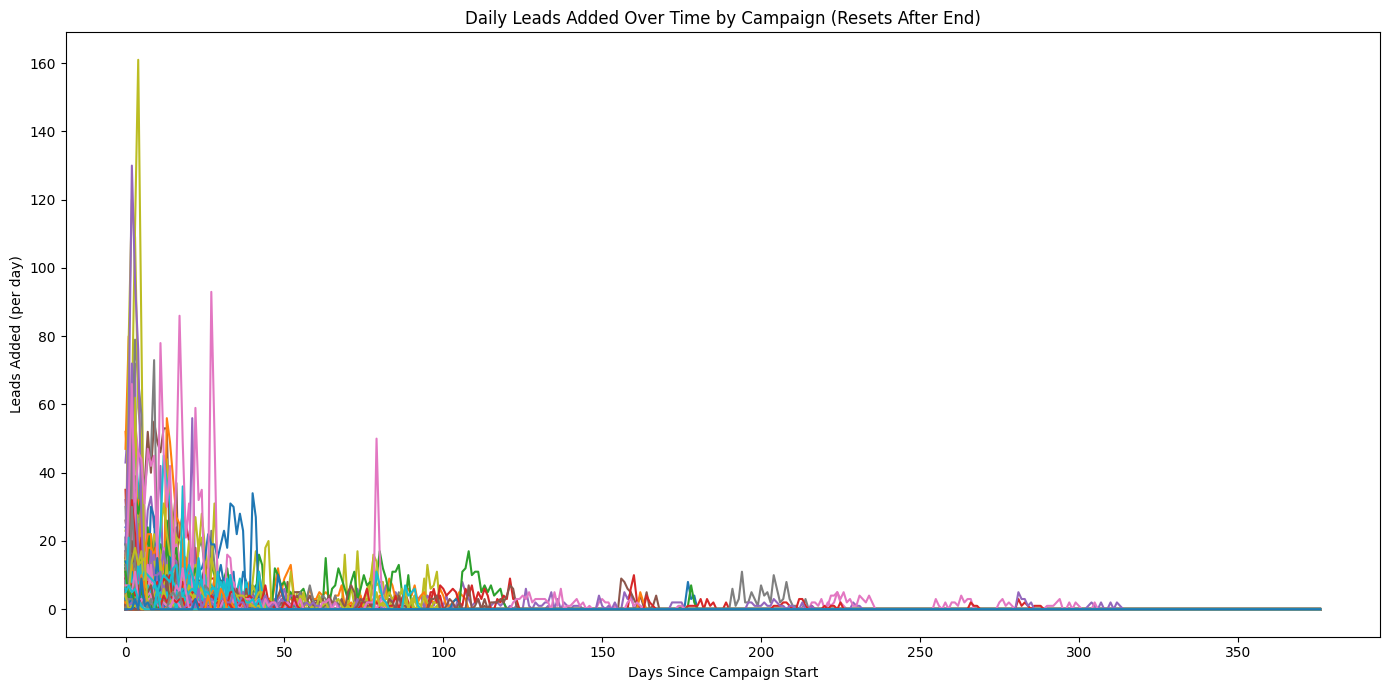

In [15]:
# Visualize leads added per day for each campaign, resetting to zero after campaign ends
import matplotlib.pyplot as plt

# Prepare data: convert added_date to datetime
leads_time = df.copy()
leads_time['added_date'] = pd.to_datetime(leads_time['added_date'])

# Merge campaign start and stop times
leads_time = pd.merge(leads_time, camp[['id', 'start_time', 'stop_time']], left_on='campaign_id', right_on='id', suffixes=('', '_camp'))
leads_time['start_time'] = pd.to_datetime(leads_time['start_time'])
leads_time['stop_time'] = pd.to_datetime(leads_time['stop_time'])
leads_time['days_since_start'] = (leads_time['added_date'] - leads_time['start_time']).dt.days

# Remove negative days (leads before campaign start)
leads_time = leads_time[leads_time['days_since_start'] >= 0]

# Group by campaign and days since start, count leads
leads_by_day = leads_time.groupby(['campaign_id', 'days_since_start']).size().reset_index(name='leads_added')

# For each campaign, fill in all days from 0 to campaign duration
plot_data = []
for cid, group in leads_by_day.groupby('campaign_id'):
    start = camp.loc[camp['id'] == cid, 'start_time'].iloc[0]
    stop = camp.loc[camp['id'] == cid, 'stop_time'].iloc[0]
    duration = (pd.to_datetime(stop) - pd.to_datetime(start)).days + 1
    days = pd.Series(range(duration), name='days_since_start')
    merged = pd.merge(days, group, on='days_since_start', how='left').fillna(0)
    merged['campaign_id'] = cid
    plot_data.append(merged)
plot_df = pd.concat(plot_data, ignore_index=True)

# Pivot for plotting
pivot = plot_df.pivot(index='days_since_start', columns='campaign_id', values='leads_added').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col])
plt.xlabel('Days Since Campaign Start')
plt.ylabel('Leads Added (per day)')
plt.title('Daily Leads Added Over Time by Campaign (Resets After End)')
plt.tight_layout()
plt.show()

#### OBSERVATIONS
1. Time series decomposition is required to remove the seasonality out of the equation 
2. The Lead quality on the peaks need to be investigated for each specific campaign (Will not do it since it's synthetic data)

## Cumulative Leads Over Time
View cumulative leads to assess sustained performance vs. early spikes.

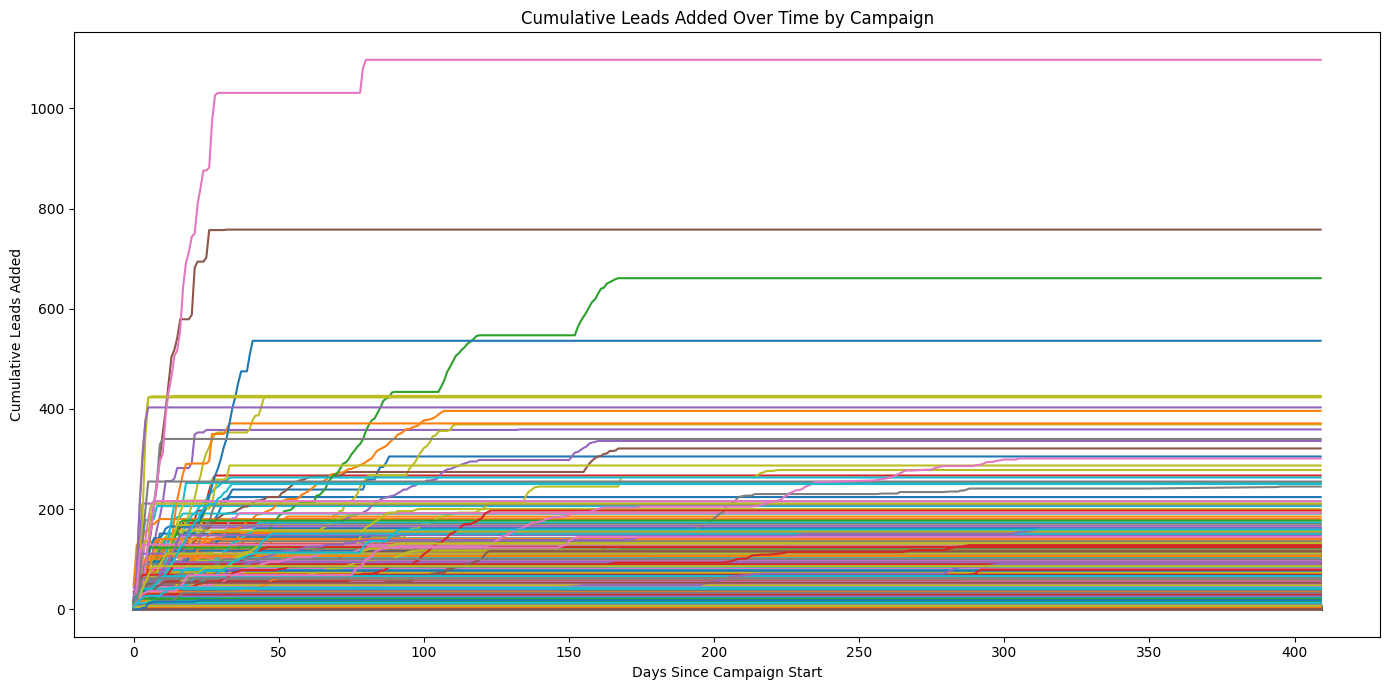

In [16]:
#convert added_date to datetime
leads_time = df.copy()
leads_time['added_date'] = pd.to_datetime(leads_time['added_date'])

# For each campaign, calculate days since campaign start and cumulative count
leads_time = pd.merge(leads_time, camp[['id', 'start_time']], left_on='campaign_id', right_on='id', suffixes=('', '_camp'))
leads_time['start_time'] = pd.to_datetime(leads_time['start_time'])
leads_time['days_since_start'] = (leads_time['added_date'] - leads_time['start_time']).dt.days

# Remove negative days (leads before campaign start)
leads_time = leads_time[leads_time['days_since_start'] >= 0]

# Group by campaign and days since start, count leads
leads_by_day = leads_time.groupby(['campaign_id', 'days_since_start']).size().reset_index(name='leads_added')

# Pivot for plotting
pivot = leads_by_day.pivot(index='days_since_start', columns='campaign_id', values='leads_added').fillna(0)
cumulative = pivot.cumsum()

# Plot
plt.figure(figsize=(14, 7))
for col in cumulative.columns:
    plt.plot(cumulative.index, cumulative[col])
plt.xlabel('Days Since Campaign Start')
plt.ylabel('Cumulative Leads Added')
plt.title('Cumulative Leads Added Over Time by Campaign')
plt.tight_layout()
plt.show()

### OBSERVATIONS:
1. The variation in campaign performance is huge with few outliers performing well, the rest are expected to not be feasible.
2. The increase occur in steps pointing to a seasonality in the campaigns performance

In [17]:
# Merge campaign info into df
df_budget = pd.merge(df, camp[['user_id','id', 'daily_budget', 'duration', 'project_name']], left_on='campaign_id', right_on='id', suffixes=('', '_camp'))

# Group by campaign_id, project_name, daily_budget, and duration to aggregate leads
campaign_group = df_budget.groupby(['user_id','campaign_id', 'project_name', 'daily_budget','duration'], as_index=False).agg({'lead_status':'count'})
campaign_group = campaign_group.rename(columns={'lead_status':'num_leads'})

# Calculate total budget for the campaign
campaign_group['budget'] = campaign_group['daily_budget'] * campaign_group['duration']

# Calculate total budget per lead for each campaign
def safe_bpl(row):
    return row['budget'] / row['num_leads'] if row['num_leads'] > 0 else float('nan')
campaign_group['budget_per_lead'] = campaign_group.apply(safe_bpl, axis=1)

campaign_group.head()

,user_id,campaign_id,project_name,daily_budget,duration,num_leads,budget,budget_per_lead
0,12,12077,Mountain View iCity October,1200,3,1,3600,3600.000000
1,12,12079,Kings Way,1200,5,3,6000,2000.000000
2,12,12115,Kings Way,13481,10,140,134810,962.928571
3,12,12116,Kings Way,7367,9,45,66303,1473.400000
4,12,12134,Kings Way,4000,6,9,24000,2666.666667


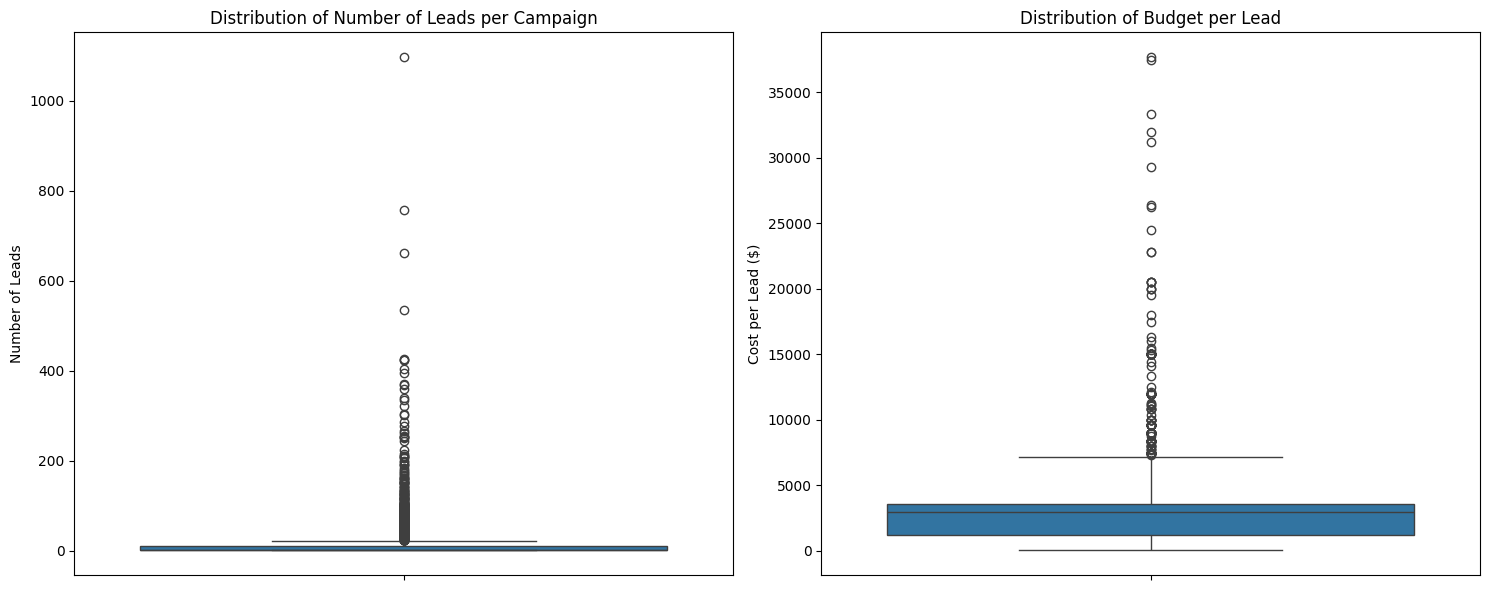

In [18]:
# Create box plots for number of leads and cost per lead
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot for number of leads
sns.boxplot(y=campaign_group['num_leads'], ax=ax1)
ax1.set_title('Distribution of Number of Leads per Campaign')
ax1.set_ylabel('Number of Leads')

# Box plot for cost per lead
sns.boxplot(y=campaign_group['budget_per_lead'], ax=ax2)
ax2.set_title('Distribution of Budget per Lead')
ax2.set_ylabel('Cost per Lead ($)')

plt.tight_layout()
plt.show()

In [19]:
campaign_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4022 entries, 0 to 4021
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          4022 non-null   int64  
 1   campaign_id      4022 non-null   int64  
 2   project_name     4022 non-null   object 
 3   daily_budget     4022 non-null   int64  
 4   duration         4022 non-null   int64  
 5   num_leads        4022 non-null   int64  
 6   budget           4022 non-null   int64  
 7   budget_per_lead  4022 non-null   float64
dtypes: float64(1), int64(6), object(1)
memory usage: 251.5+ KB


In [20]:
campaign_group.sort_values(by='budget_per_lead',ascending=False).head(20)

,user_id,campaign_id,project_name,daily_budget,duration,num_leads,budget,budget_per_lead
2685,1195,11129,Marakez - District 5,1500,377,15,565500,37700.0
653,374,8375,Club Hills Residence - ZAYED by HDP,2499,15,1,37485,37485.0
1391,468,13701,Ivoire West - PRE,12830,13,5,166790,33358.0
2525,1095,9583,Nile Business City,2000,16,1,32000,32000.0
2526,1095,9589,The Butterfly,1200,26,1,31200,31200.0
1330,468,10234,Mountain View iCity October,1222,24,1,29328,29328.0
855,414,6801,Karnak compound - zayed,1200,22,1,26400,26400.0
1317,468,8632,Plage,5000,21,4,105000,26250.0
3186,1318,10747,Garden Lakes,3500,7,1,24500,24500.0
3563,1526,12640,Kings Way,1200,19,1,22800,22800.0


In [21]:
campaign_group.sort_values(by='budget_per_lead',ascending=True).head(20)

,user_id,campaign_id,project_name,daily_budget,duration,num_leads,budget,budget_per_lead
1692,837,8455,Vinci,1200,3,136,3600,26.470588
753,398,7805,Sarai,1200,8,206,9600,46.601942
1369,468,12763,Kings Way,2000,18,426,36000,84.507042
1527,588,7500,Baron City,1200,5,64,6000,93.750000
754,398,7811,Sarai,1200,12,151,14400,95.364238
3391,1402,11569,Nig development - Giza,1200,3,37,3600,97.297297
98,75,8691,Shamasi - serac sidi abdelrahman,1200,7,85,8400,98.823529
57,44,7400,Telal Sokhna - PRE,1200,5,58,6000,103.448276
1526,588,7303,Next Life - Zahra Maadi,1200,5,56,6000,107.142857
97,75,8684,Shamasi - serac sidi abdelrahman,1200,7,78,8400,107.692308


#### Observations
1. Budget per lead is nonesensical
2. The Budget per lead while not a common marketing KPI it shows the intent of the client to attract substantially more leads than the campaign was able to  
3. The higher the number to the actual CPL the higher the expectations the customer had

#### Summary of leads/campaigns:
1. The number of concluded leads to the number of total leads is too low pointing towards a bottleneck in the process of conversion
2. The assumptions made to calculate the qualified leads percentage needs to be matched with the actual criterea
3. A pre-requisit A/B Testing should be done on the campaign to get a baseline Cost-per-lead and a ratio of qualified leads prior to launching a full campaign

In [22]:
ins.head()

,ad_set_id,campaign_id,reach,spend,clicks,impressions,created_at
0,16588,6493,848,164.62,77,1015,2024-06-01 00:00:00
1,16588,6493,697,76.82,43,764,2024-06-02 00:00:00
2,16589,6493,643,117.27,50,766,2024-06-01 00:00:00
3,16589,6493,668,58.01,49,736,2024-06-02 00:00:00
4,16590,6493,1345,163.26,117,1567,2024-06-01 00:00:00


In [23]:
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68733 entries, 0 to 68732
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ad_set_id    68733 non-null  int64  
 1   campaign_id  68733 non-null  int64  
 2   reach        68733 non-null  int64  
 3   spend        68733 non-null  float64
 4   clicks       68733 non-null  int64  
 5   impressions  68733 non-null  int64  
 6   created_at   68733 non-null  object 
dtypes: float64(1), int64(5), object(1)
memory usage: 3.7+ MB


In [24]:
ins.describe()

,ad_set_id,campaign_id,reach,spend,clicks,impressions
count,68733.000000,68733.000000,68733.000000,68733.000000,68733.000000,68733.000000
mean,29123.352844,10942.996465,2578.802904,361.577286,91.851061,2904.762312
std,7185.708457,2531.103507,9532.430629,1121.072353,300.608687,11487.891818
min,16588.000000,6493.000000,0.000000,0.010000,0.000000,1.000000
25%,23033.000000,8824.000000,185.000000,45.550000,5.000000,197.000000
50%,28721.000000,10812.000000,594.000000,141.630000,20.000000,642.000000
75%,35636.000000,13235.000000,1884.000000,366.110000,72.000000,2067.000000
max,41395.000000,15251.000000,554572.000000,55035.640000,16640.000000,652900.000000


In [25]:
df1=ins.groupby(['campaign_id']).agg({'clicks':'sum','spend':'sum'}).reset_index()

In [26]:
df2=campaign_group.merge(df1,on='campaign_id')
df2.head(10)

,user_id,campaign_id,project_name,daily_budget,duration,num_leads,budget,budget_per_lead,clicks,spend
0,12,12077,Mountain View iCity October,1200,3,1,3600,3600.000000,20,508.27
1,12,12079,Kings Way,1200,5,3,6000,2000.000000,230,1612.84
2,12,12115,Kings Way,13481,10,140,134810,962.928571,12522,52247.29
3,12,12116,Kings Way,7367,9,45,66303,1473.400000,6411,20669.02
4,12,12134,Kings Way,4000,6,9,24000,2666.666667,860,4518.38
5,12,12139,Kings Way,1200,3,1,3600,3600.000000,110,777.11
6,12,12142,Kings Way,1200,3,1,3600,3600.000000,65,763.92
7,12,12331,Kings Way,7367,8,107,58936,550.803738,10185,21942.22
8,12,12332,Kings Way,7367,8,123,58936,479.154472,24717,23122.97
9,12,12334,Kings Way,7367,8,80,58936,736.700000,8340,23003.26


In [27]:
df2['budget'].corr(df2['spend']),df2['num_leads'].corr(df2['clicks'])

(np.float64(0.4402206156071004), np.float64(0.7229873846970599))

#### Observations:
1. There is a weak correlation between the total 'spend' column per campaign and the total budget from the campaigns dataset
2. There is a strong correlation between the number of leads per campaign and the number of clicks

In [28]:
ins.campaign_id.value_counts()

campaign_id
14932    451
9183     294
9235     287
14408    276
10569    269
        ... 
14216      1
14421      1
14415      1
7204       1
14750      1
Name: count, Length: 6821, dtype: int64

In [29]:
ins[ins.campaign_id==14932]['spend']

64987      0.74
64988      0.07
64989      0.05
64990      0.02
64991      0.13
          ...  
65433    487.43
65434    523.95
65435    280.19
65436    641.21
65437    527.47
Name: spend, Length: 451, dtype: float64

In [30]:
# Aggregate insights by campaign_id: sum metrics and compute start/end dates
# Assumptions: a timestamp column named 'created_at' exists in `ins` and metrics 'clicks','spend','impressions','reach' are present.
# If your timestamp column has a different name (e.g., 'date'), change the column name below.

ins['created_at'] = pd.to_datetime(ins['created_at'])

agg_cols = {
    'clicks': 'sum',
    'spend': 'sum',
    'impressions': 'sum',
    'reach': 'sum'
}

# Group and sum numeric metrics
ins_campaign = ins.groupby('campaign_id').agg(agg_cols).reset_index()

# Compute start and end dates for each campaign based on created_at
dates = (
    ins.groupby('campaign_id')
       .agg(start_date=('created_at', 'min'), end_date=('created_at', 'max'))
       .reset_index()
)

# Merge dates into the aggregated metrics
ins_campaign = ins_campaign.merge(dates, on='campaign_id')

# Optional: reorder columns for readability
cols = ['campaign_id', 'start_date', 'end_date', 'clicks', 'spend', 'impressions', 'reach']
ins_campaign = ins_campaign[cols]

ins_campaign.head()

,campaign_id,start_date,end_date,clicks,spend,impressions,reach
0,6493,2024-06-01,2024-06-02,418,689.19,6270,5461
1,6496,2024-06-01,2024-06-03,156,2137.86,8019,7352
2,6497,2024-06-01,2024-06-02,125,888.43,8091,7510
3,6499,2024-06-01,2024-06-02,11,354.40,713,665
4,6500,2024-06-02,2024-06-03,62,842.40,1086,943


In [31]:
# Merge ins_campaign with df2 and compute CTR and CPL
# This cell assumes `ins_campaign` and `df2` exist (ins_campaign from the aggregated insights, df2 from campaign_group merge).
import numpy as np

if 'ins_campaign' not in globals():
    raise NameError('ins_campaign not found — run the insights aggregation cell first')
if 'df2' not in globals():
    raise NameError('df2 not found — run the campaign/insights merge cell first')

# Rename aggregated columns to avoid clashes
ins_agg = ins_campaign.rename(columns={
    'clicks': 'clicks_ins',
    'spend': 'spend_ins',
    'impressions': 'impressions_ins',
    'reach': 'reach_ins'
})

# Merge the dataframes (left join to keep campaigns in df2)
campaign_metrics = df2.merge(ins_agg, on='campaign_id', how='left')

# Prefer insights-derived clicks/spend when available, otherwise keep existing df2 values
if 'clicks_ins' in campaign_metrics.columns:
    campaign_metrics['clicks'] = campaign_metrics['clicks_ins'].fillna(campaign_metrics.get('clicks'))
if 'spend_ins' in campaign_metrics.columns:
    campaign_metrics['spend'] = campaign_metrics['spend_ins'].fillna(campaign_metrics.get('spend'))

# Determine impressions column to use
if 'impressions_ins' in campaign_metrics.columns:
    imp_col = 'impressions_ins'
elif 'impressions' in campaign_metrics.columns:
    imp_col = 'impressions'
else:
    imp_col = None

# Compute CTR (%) safely
if imp_col is not None:
    campaign_metrics['ctr'] = (campaign_metrics['clicks'] / campaign_metrics[imp_col] * 100).replace([np.inf, -np.inf], np.nan)
else:
    campaign_metrics['ctr'] = np.nan

# Compute Cost Per Lead (CPL): spend / num_leads when num_leads > 0
if 'num_leads' in campaign_metrics.columns:
    campaign_metrics['cpl'] = campaign_metrics.apply(lambda r: (r['spend'] / r['num_leads']) if (pd.notnull(r.get('spend')) and pd.notnull(r.get('num_leads')) and r['num_leads']>0) else np.nan, axis=1)
else:
    campaign_metrics['cpl'] = np.nan

# Optional: tidy column names for presentation
present_cols = ['campaign_id']
for col in ['start_date','end_date','project_name','num_leads','daily_budget','duration','budget']:
    if col in campaign_metrics.columns:
        present_cols.append(col)

for col in ['clicks','impressions_ins','reach_ins','spend','ctr','cpl']:
    if col in campaign_metrics.columns:
        present_cols.append(col)

# Show result
campaign_metrics = campaign_metrics.loc[:, present_cols]
campaign_metrics.head()


,campaign_id,start_date,end_date,project_name,num_leads,daily_budget,duration,budget,clicks,impressions_ins,reach_ins,spend,ctr,cpl
0,12077,2024-10-10,2024-10-11,Mountain View iCity October,1,1200,3,3600,20,737,704,508.27,2.713704,508.270000
1,12079,2024-10-10,2024-10-13,Kings Way,3,1200,5,6000,230,7701,7138,1612.84,2.986625,537.613333
2,12115,2024-10-11,2024-10-19,Kings Way,140,13481,10,134810,12522,458028,411847,52247.29,2.733894,373.194929
3,12116,2024-10-11,2024-10-18,Kings Way,45,7367,9,66303,6411,323129,297937,20669.02,1.984037,459.311556
4,12134,2024-10-11,2024-10-14,Kings Way,9,4000,6,24000,860,38861,35046,4518.38,2.213016,502.042222


In [32]:
campaign_metrics.describe()

,campaign_id,start_date,end_date,num_leads,daily_budget,duration,budget,clicks,impressions_ins,reach_ins,spend,ctr,cpl
count,4020.000000,4020,4020,4020.000000,4020.00000,4020.000000,4.020000e+03,4020.000000,4.020000e+03,4.020000e+03,4.020000e+03,4020.000000,4020.000000
mean,10949.948010,2024-09-12 10:35:06.268656896,2024-09-19 11:20:35.820895488,14.169900,1935.10796,7.806716,1.726252e+04,1527.303234,4.723993e+04,4.180946e+04,5.781121e+03,3.571310,691.674971
min,6493.000000,2024-06-01 00:00:00,2024-06-02 00:00:00,1.000000,1200.00000,1.000000,2.400000e+03,0.000000,1.370000e+02,1.370000e+02,6.048000e+01,0.000000,3.710809
25%,8794.250000,2024-07-30 00:00:00,2024-08-04 00:00:00,1.000000,1200.00000,3.000000,3.600000e+03,66.000000,2.576750e+03,2.370500e+03,7.245150e+02,1.883413,383.608953
50%,11024.000000,2024-09-17 00:00:00,2024-09-22 00:00:00,2.000000,1200.00000,5.000000,6.000000e+03,196.000000,6.927500e+03,6.337000e+03,1.418450e+03,2.926829,555.395000
75%,13106.250000,2024-10-22 00:00:00,2024-10-25 00:00:00,10.000000,2000.00000,7.000000,1.200000e+04,827.250000,2.441275e+04,2.225875e+04,3.895115e+03,4.584873,733.137500
max,15249.000000,2025-01-04 00:00:00,2025-10-28 00:00:00,1097.000000,100000.00000,377.000000,2.220000e+06,307430.000000,9.596851e+06,6.407176e+06,1.246693e+06,19.346586,260086.610000
std,2493.200626,NaN,NaN,41.826693,3181.31939,17.704598,5.965190e+04,6985.537016,2.747480e+05,2.125654e+05,3.050953e+04,2.397750,4317.802112


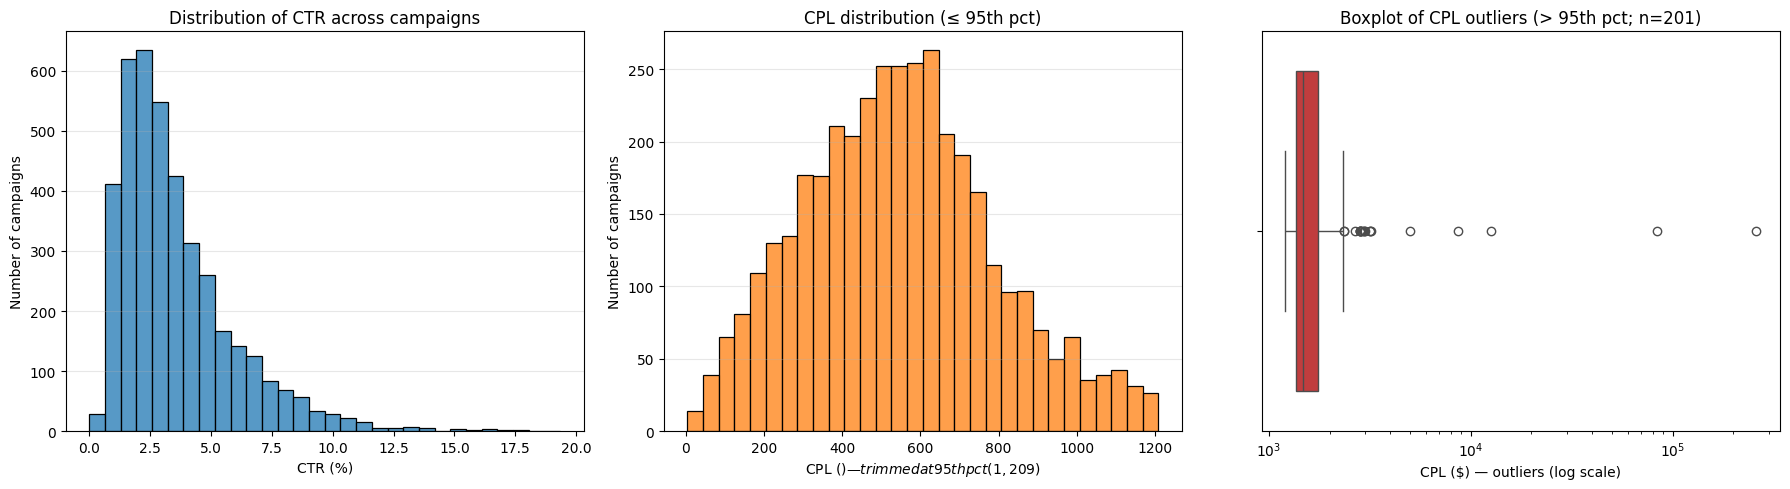

CTR values available: 4020
CPL non-null: 4020, positive CPLs: 4020
95th percentile of positive CPLs: 1,209$
Number of outliers > 95th pct: 201; max CPL: 260,087$


In [40]:
# Plots: CTR histogram, CPL histogram trimmed to 95th percentile, and boxplot for CPL outliers (>95th pct)
# Requires `campaign_metrics` with 'ctr' and 'cpl' columns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if 'campaign_metrics' not in globals():
    raise NameError('campaign_metrics not found — run the merge/metrics cell first')

# Ensure columns exist; compute ctr if possible
if 'ctr' not in campaign_metrics.columns:
    # attempt to compute from available columns
    if 'clicks' in campaign_metrics.columns and ('impressions_ins' in campaign_metrics.columns or 'impressions' in campaign_metrics.columns):
        imp_col = 'impressions_ins' if 'impressions_ins' in campaign_metrics.columns else 'impressions'
        campaign_metrics['ctr'] = (campaign_metrics['clicks'] / campaign_metrics[imp_col] * 100).replace([np.inf, -np.inf], np.nan)
    else:
        campaign_metrics['ctr'] = np.nan

if 'cpl' not in campaign_metrics.columns:
    campaign_metrics['cpl'] = np.nan

ctr_data = campaign_metrics['ctr'].dropna()
cpl_data = campaign_metrics['cpl'].dropna()
cpl_pos = cpl_data[cpl_data > 0]

# Setup figure with 3 panels
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) CTR histogram
if len(ctr_data) == 0:
    axes[0].text(0.5, 0.5, 'No CTR values available', ha='center', va='center', fontsize=12)
    axes[0].set_title('CTR (%)')
    axes[0].set_xlabel('CTR (%)')
    axes[0].set_ylabel('Number of campaigns')
else:
    sns.histplot(ctr_data, bins=30, kde=False, ax=axes[0], color='C0', edgecolor='black')
    axes[0].set_xlabel('CTR (%)')
    axes[0].set_ylabel('Number of campaigns')
    axes[0].set_title('Distribution of CTR across campaigns')
    axes[0].grid(axis='y', alpha=0.3)

# 2) CPL histogram trimmed at pct percentile (default 95)
if len(cpl_pos) == 0:
    axes[1].text(0.5, 0.5, 'No positive CPL values available', ha='center', va='center', fontsize=12)
    axes[1].set_title('CPL ($) — trimmed')
    axes[1].set_xlabel('CPL ($)')
    axes[1].set_ylabel('Number of campaigns')
else:
    pct = 95
    p_pct = np.nanpercentile(cpl_pos, pct)
    trimmed = cpl_pos[cpl_pos <= p_pct]
    sns.histplot(trimmed, bins=30, kde=False, ax=axes[1], color='C1', edgecolor='black')
    axes[1].set_xlabel(f'CPL ($) — trimmed at {pct}th pct ({p_pct:,.0f}$)')
    axes[1].set_ylabel('Number of campaigns')
    axes[1].set_title(f'CPL distribution (≤ {pct}th pct)')
    axes[1].grid(axis='y', alpha=0.3)

# 3) Boxplot for CPL outliers only (> pct)
if len(cpl_pos) == 0:
    axes[2].text(0.5, 0.5, 'No positive CPL values', ha='center', va='center', fontsize=12)
    axes[2].set_title('CPL outliers')
else:
    # compute outliers > pct
    pct = 95
    p_pct = np.nanpercentile(cpl_pos, pct)
    outliers = cpl_pos[cpl_pos > p_pct]
    if len(outliers) == 0:
        axes[2].text(0.5, 0.5, f'No CPL values above {pct}th percentile', ha='center', va='center', fontsize=12)
        axes[2].set_title('CPL outliers')
    else:
        sns.boxplot(x=outliers, ax=axes[2], color='C3')
        axes[2].set_xscale('log')
        axes[2].set_xlabel('CPL ($) — outliers (log scale)')
        axes[2].set_title(f'Boxplot of CPL outliers (> {pct}th pct; n={len(outliers)})')

plt.tight_layout()
plt.show()

# Print a concise summary
print(f'CTR values available: {len(ctr_data)}')
print(f'CPL non-null: {len(cpl_data)}, positive CPLs: {len(cpl_pos)}')
if len(cpl_pos)>0:
    print(f'{pct}th percentile of positive CPLs: {p_pct:,.0f}$')
    print(f'Number of outliers > {pct}th pct: {len(outliers) if len(cpl_pos)>0 else 0}; max CPL: {cpl_pos.max():,.0f}$')

# Suggest next steps if many outliers
if len(cpl_pos)>0 and len(outliers)/len(cpl_pos) > 0.1:
    print('\nNote: >10% of positive CPLs are above the trimming percentile. Consider inspecting those campaigns or lowering the percentile (e.g., 90).')

#### SUMMARY:
1. CTR looks very good on average, but depending on the medium a detailed comparison can reveal areas of improvement if there are any
2. CPL is substantially high. Historical data could aid in reaching a better judgement seeing that many of the projects are on the luxury side, but overall it is on the higher.
3. The outliers in the CPL are few, but require indepth analysis of the campaigns to see where they went wrong.

In [ ]:
df2.to_csv('part2/data/campaign_group.csv', index=False)
campaign_metrics.to_csv('part2/data/campaign_metrics.csv', index=False)

In [ ]:
qualified_by_campaign.to_csv('part2/data/qualified_by_campaign.csv', index=False)

In [34]:
ins_campaign[ins_campaign.campaign_id==14932]

,campaign_id,start_date,end_date,clicks,spend,impressions,reach
6602,14932,2024-12-06,2025-10-08,30025,101531.32,1165338,1071976


In [35]:
# Let's examine the basic information about each dataset
print("Campaign Leads Dataset:")
print(cl.info())
print("\nShape:", cl.shape)
print("\nFirst few rows:")
print(cl.head())

print("\n" + "="*50 + "\n")

print("Campaigns Dataset:")
print(camp.info())
print("\nShape:", camp.shape)
print("\nFirst few rows:")
print(camp.head())

print("\n" + "="*50 + "\n")

print("Insights Dataset:")
print(ins.info())
print("\nShape:", ins.shape)
print("\nFirst few rows:")
print(ins.head())

print("\n" + "="*50 + "\n")

print("Lead Status Changes Dataset:")
print(ls.info())
print("\nShape:", ls.shape)
print("\nFirst few rows:")
print(ls.head())

Campaign Leads Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56965 entries, 0 to 56964
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           56965 non-null  int64 
 1   campaign_id  56965 non-null  int64 
 2   name         56965 non-null  object
 3   email        56965 non-null  object
 4   phone        56965 non-null  object
 5   lead_status  56965 non-null  object
 6   added_date   56965 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.0+ MB
None

Shape: (56965, 7)

First few rows:
      id  campaign_id                   name                       email  \
0  77930         6496         Vicky Mohr Sr.      smith.oren@example.org   
1  77942         6496         Clovis Mueller       toy.korey@example.net   
2  77964         6493     Austin Ondricka II           hveum@example.org   
3  77983         6500            Jaquan Kuhn  greenholt.elsa@example.com   
4  77988         6496  Prof.

# Missing Values Analysis

Let's check for missing values in each dataset to understand data completeness.

In [36]:
# Check missing values in each dataset
print("Missing values in Campaign Leads Dataset:")
print(cl.isnull().sum())
print("\nMissing values percentage:")
print((cl.isnull().sum() / len(cl) * 100).round(2))

print("\n" + "="*50 + "\n")

print("Missing values in Campaigns Dataset:")
print(camp.isnull().sum())
print("\nMissing values percentage:")
print((camp.isnull().sum() / len(camp) * 100).round(2))

print("\n" + "="*50 + "\n")

print("Missing values in Insights Dataset:")
print(ins.isnull().sum())
print("\nMissing values percentage:")
print((ins.isnull().sum() / len(ins) * 100).round(2))

print("\n" + "="*50 + "\n")

print("Missing values in Lead Status Changes Dataset:")
print(ls.isnull().sum())
print("\nMissing values percentage:")
print((ls.isnull().sum() / len(ls) * 100).round(2))

Missing values in Campaign Leads Dataset:
id             0
campaign_id    0
name           0
email          0
phone          0
lead_status    0
added_date     0
dtype: int64

Missing values percentage:
id             0.0
campaign_id    0.0
name           0.0
email          0.0
phone          0.0
lead_status    0.0
added_date     0.0
dtype: float64


Missing values in Campaigns Dataset:
id              0
daily_budget    0
start_time      0
stop_time       0
user_id         0
project_name    0
duration        0
dtype: int64

Missing values percentage:
id              0.0
daily_budget    0.0
start_time      0.0
stop_time       0.0
user_id         0.0
project_name    0.0
duration        0.0
dtype: float64


Missing values in Insights Dataset:
ad_set_id      0
campaign_id    0
reach          0
spend          0
clicks         0
impressions    0
created_at     0
dtype: int64

Missing values percentage:
ad_set_id      0.0
campaign_id    0.0
reach          0.0
spend          0.0
clicks         